In [5]:
import pandas as pd
import wandb
import collections
import seaborn as sns

import matplotlib.pyplot as plt

# start less verbose seaborn
import warnings

warnings.filterwarnings("ignore")
# end less verbose seaborn end

# start better plot
import scienceplots

sns.set(font_scale=1.0, rc={"text.usetex": True})
plt.style.use("ieee")
# end better plot

# supress scientific number notation, display only 2  digits after comma
pd.options.display.float_format = '{:.2f}'.format

# Distortion factor is called sigma for all distortions
# in paper, but it is called differently in the imple-
# mentation (sigma, q, factor)
tag_to_val = [
    ("Noise", "sigma"),
    ("Blur", "sigma"),
    ("JPEG", "q"),
    ("Contrast", "factor"),
    ("Rescale", "factor"),
    ("Grid", "factor"),
]
timmname2print = {
    "vit_large_patch16_224": "ViT Large",
    "vit_base_patch16_224": "ViT Base",
    "vit_small_patch16_224": "ViT Small",
    "vit_tiny_patch16_224": "ViT Tiny",
    "tf_efficientnet_b0": "EfficientNet-B0",
    "tf_efficientnet_b1": "EfficientNet-B1",
    "tf_efficientnet_b2": "EfficientNet-B2",
    "tf_efficientnet_b3": "EfficientNet-B3",
    "tf_efficientnet_b4": "EfficientNet-B4",
    "tf_efficientnet_b5": "EfficientNet-B5",
    "tf_efficientnet_b6": "EfficientNet-B6",
    "tf_efficientnet_b7": "EfficientNet-B7",
    "swin_tiny_patch4_window7_224": "Swin Tiny",
    "swin_small_patch4_window7_224": "Swin Small",
    "swin_base_patch4_window7_224": "Swin Base",
    "swin_large_patch4_window7_224": "Swin Large",
    "convnext_atto": "ConvNeXt Atto",
    "convnext_base": "ConvNeXt Base",
    "convnext_femto": "ConvNeXt Femto",
    "convnext_large": "ConvNeXt Large",
    "convnext_nano": "ConvNeXt Nano",
    "convnext_pico": "ConvNeXt Pico",
    "convnext_small": "ConvNeXt Small",
    "convnext_tiny": "ConvNeXt Tiny",
    "convnext_xlarge": "ConvNeXt XLarge",
    "mobilenetv3_small_050": "MobileNetV3 Small 0.50",
    "mobilenetv3_small_075": "MobileNetV3 Small 0.75",
    "mobilenetv3_small_100": "MobileNetV3 Small 1.00",
    "resnet26d": "ResNetD 26",
    "resnet18d": "ResNetD 18",
    "resnet34d": "ResNetD 34",
    "resnet101d": "ResNetD 101",
    "resnet152d": "ResNetD 152",
    "resnet200d": "ResNetD 200",
}

DATACSV = './experiment.csv'

In [4]:
# # Download experiment results from wandb logs.
# # Can be run only once to create experiment.csv
# api = wandb.Api()

# data = collections.defaultdict(list)
# for t_v in tag_to_val:
#     idx = 0
#     runs = api.runs(
#         "petrdvoracek/adversarial",
#         {"$and": [{"group": "advgen_baseline2", "tags": t_v[0]}]},
#     )
#     print(f"Found {len(runs)} runs with distortion {t_v[0]}")

#     for run in runs:
#         # .summary contains the output keys/values for metrics like accuracy.
#         #  We call ._json_dict to omit large files
#         summary = run.summary

#         data["error"].append(summary["eval_error_top1_adv_epoch"])
#         data["params"].append(summary["params"])
#         data["model_name"].append(summary["model_name"])
#         data["base_arch"].append(summary["base_architecture"])
#         data["input_size"].append(summary["input_size"])
#         data["factor"].append(summary[t_v[1]])
#         data["distortion"].append(t_v[0])

# runs_df = pd.DataFrame(data)
# runs_df.to_csv(DATACSV)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [6]:
df = pd.read_csv(DATACSV, index_col=0)
# print(df.isnull().values.any())

# remove timm pretrained effnet
df = df.drop(
    df[df["model_name"].str.startswith("efficientnet")].index, axis="rows"
)
# remove meaningless data which results in 1.0 error rate
# (if contrast is 0.0 image is totally black)
df = df.drop(
    df[(df["distortion"] == "Contrast") & (df["factor"] == 0.0)].index, axis="rows"
)  
# #remove meaningless data which results in 1.0 error rate
# (if rescale is 0.01 (meaning 100x downscale), images is destroyed too much)
df = df.drop(
    df[(df["distortion"] == "Rescale") & (df["factor"] == 0.01)].index, axis="rows"
)
# rename timm model names to more readable
for k, v in timmname2print.items():
    df = df.replace(k, v)

In [7]:
df["error_min"] = df.groupby("model_name")["error"].transform("min")
df["error_max"] = df.groupby("model_name")["error"].transform("max")
df["error_diff"] = df["error"] - df["error_min"]
# df["error_diff_prec"] = df["error"] / df["error_min"] * 100
df["error_diff_max"] = df["error_max"] - df["error_min"]
df["error_diff_max_perc"] = (df["error_max"] / df["error_min"] * 100).astype(int)
df["error_diff_mean"] = (
    df.groupby("model_name")["error_diff"].transform("sum") / 76
)
# df['model_measurement_count'] = df.groupby('model_name')['error'].count()
# df['error_total_mean'] = df['error_sum'] / 76
# print(df[df['model_name'] == 'EfficientNet-B0'].duplicated(['factor', 'distortion']).sum())

# check all models has same number of calculations
model_calc_counts = [x for x in df.groupby("model_name")['error'].count()]
assert all(x == model_calc_counts[0] for x in model_calc_counts), "number of calculations for some  models is not the same"

In [8]:
print(df.corr(numeric_only=True)["error_diff_mean"])
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x="params", y="error_total_mean", hue="base_arch", legend=True)

error                  0.39
params                -0.50
input_size            -0.58
factor                -0.00
error_min              0.68
error_max              0.78
error_diff             0.21
error_diff_max         0.15
error_diff_max_perc   -0.63
error_diff_mean        1.00
Name: error_diff_mean, dtype: float64


In [ ]:
df


In [ ]:
df.groupby('distortion').get_group('Blur')[df['model_name'] == 'EfficientNet-B7'].sort_values('error_diff')

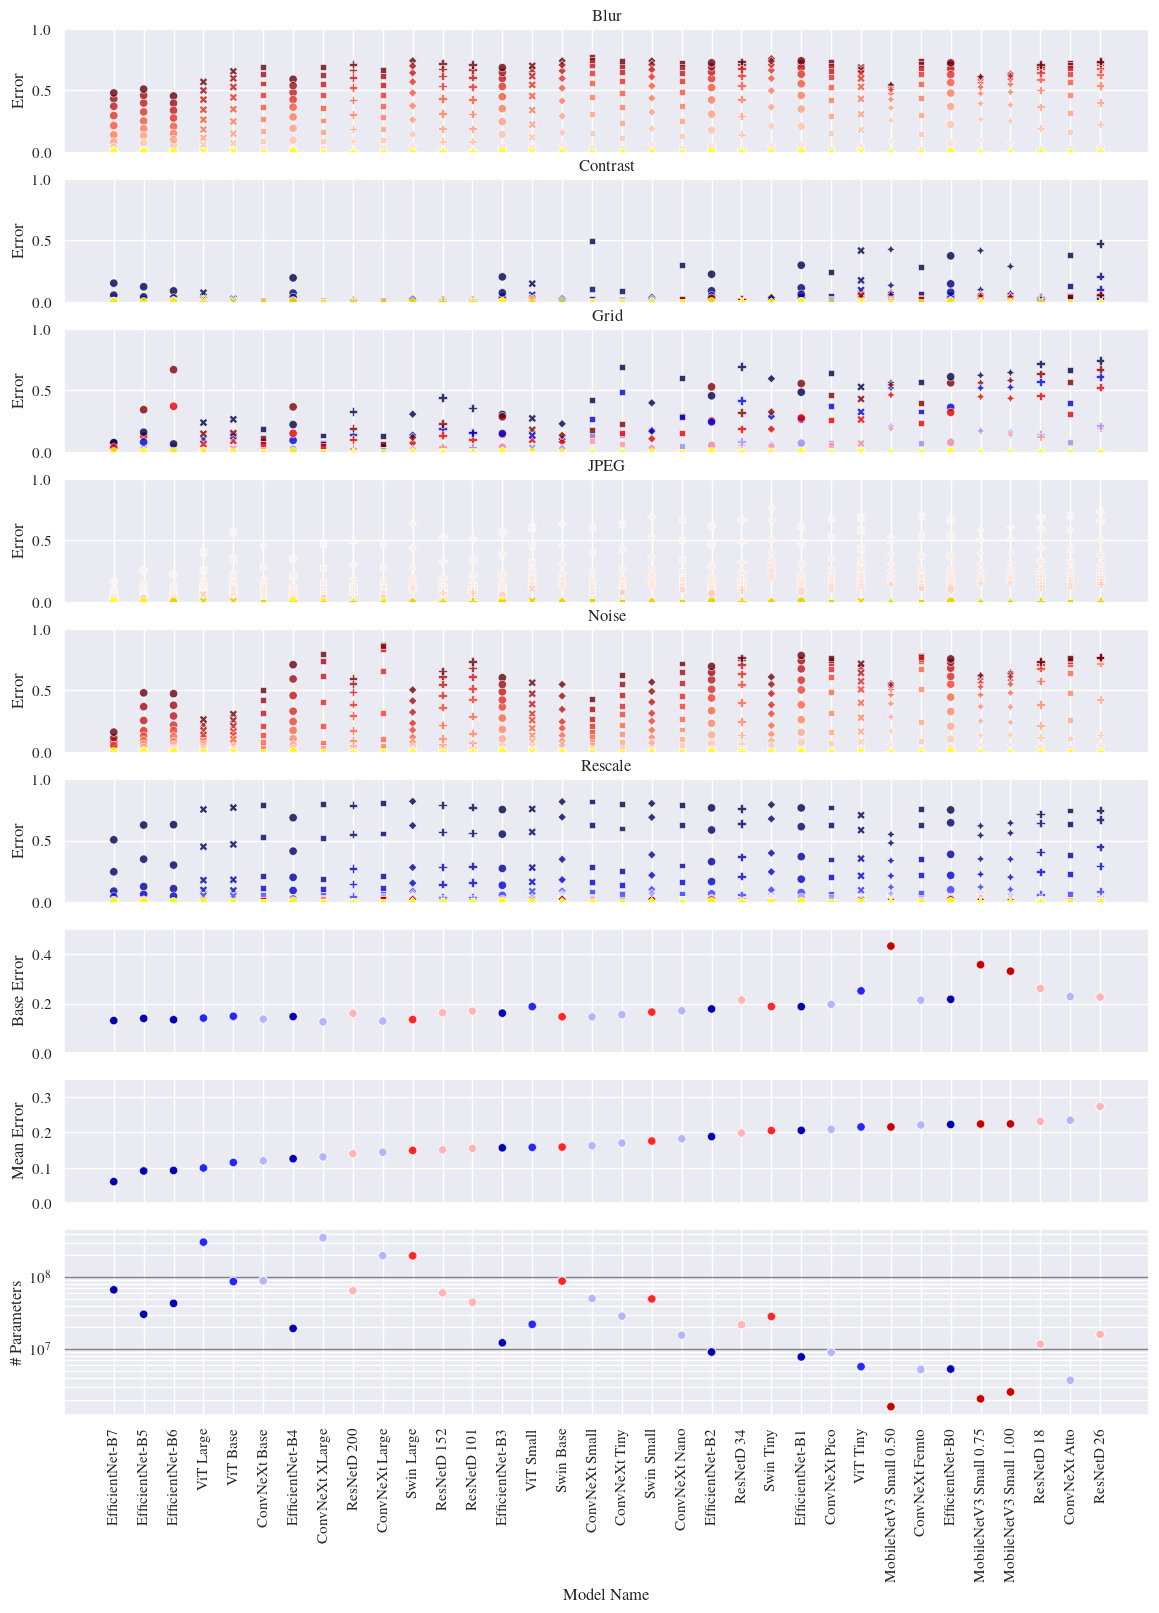

In [10]:
fig, axis = plt.subplots(9, 1, figsize=(14, 2 * 9), height_ratios=[1] * 8 + [1.5], dpi=100)
palette = {
    "mobilenetv3": "#0C5DA5",
    "convnext": "#00B945",
    "efficientnet": "#FF9500",
    "vit": "#FF2C00",
    "resnet": "#845B97",
    "swin": "#474747",
}
sortby = "error_diff_mean" # used in the paper
# sortby = 'params'
# sortby = 'error_min'
# sortby = ['base_arch', 'params']
for i, ((gname, group), ax) in enumerate(zip(df.groupby("distortion"), axis)):
    group = group.sort_values(by=sortby)
    # print(group.groupby('model_name'))
    if gname == 'Contrast' or gname == 'Grid' or gname == 'Rescale':
        base_factor = 1.0
        palette = 'seismic'
    elif gname == 'JPEG':
        base_factor = 100
        palette = 'Reds'
    else:
        base_factor = 0
        palette = 'Reds'
    alpha = 0.8
    sns.scatterplot(
        ax=ax,
        data=group,
        x="model_name",
        y="error_diff",
        hue="factor",
        style="base_arch",
        legend=False,
        # palette=["black", (1,0,0,20/255), (1,0,0,60/255), (1,0,0,120/255), (1,0,0,1)],
        palette=palette,
        alpha=alpha
    )
    sns.scatterplot(
        ax=ax,
        data=group[group["factor"] == base_factor],
        x="model_name",
        y="error_diff",
        hue="factor",
        style="base_arch",
        legend=False,
        # palette=["black", (1,0,0,20/255), (1,0,0,60/255), (1,0,0,120/255), (1,0,0,1)],
        palette=['yellow'],
        alpha=alpha
    )

    # This adds individual calculation accuracy as points to the plot
    # sns.stripplot(ax=ax, data=group, x='model_name', y='error', legend=False, hue='factor', alpha=0.7, jitter=False)
    ax.set_title(gname)
    ax.set_ylabel("Error")
    ax.set_yticks([0, 0.5, 1.0])
    if i < len(axis) - 1:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Model Name")
        ax.tick_params(axis="x", rotation=90)
    ax.set_ylim(-0.01, 1)
    # lgd = ax.legend(group['factor'], loc="center right", bbox_to_anchor=(1.3, 0.5))
    # fig.artists.append(lgd) # Here's the change
    # fig.colorbar

df = df.sort_values(by=sortby)

ax = sns.scatterplot(
    ax=axis[-3],
    data=df,
    x="model_name",
    y="error_min",
    hue="base_arch",
    legend=False,
    palette=palette,
    alpha=0.8,
)
axis[-3].set_xticklabels([])
axis[-3].set_ylim(0, 0.5)
for c in ax.containers:
    ax.bar_label(c, fmt="%0.3f")
axis[-3].set_ylabel("Base Error")
axis[-3].set_xlabel("")


ax = sns.scatterplot(
    ax=axis[-2],
    data=df,
    x="model_name",
    y="error_diff_mean",
    hue="base_arch",
    legend=False,
    palette=palette,
    alpha=0.8,
)
axis[-2].set_xticklabels([])
axis[-2].set_ylim(0, 0.35)
for c in ax.containers:
    ax.bar_label(c, fmt="%0.3f")
axis[-2].set_ylabel("Mean Error")
axis[-2].set_xlabel("")


sns.scatterplot(
    ax=axis[-1],
    data=df,
    x="model_name",
    y="params",
    hue="base_arch",
    legend=False,
    palette=palette,
    alpha=0.8,
)
axis[-1].set_yscale("log")
axis[-1].tick_params(axis="x", rotation=90)
axis[-1].grid(True, which="both", axis="y")
axis[-1].grid(True, which="major", color="gray", axis="y")
axis[-1].set_ylabel("\# Parameters")
axis[-1].set_xlabel("Model Name")
plt.show()

In [ ]:
baselines = df[df["factor"] == 0.0]